## Облачные сервисы

Многие задачи ИИ - типовые, поэтому облачные провайдеры (как крупные игроки: Microsoft, Amazon, Yandex, так и стартапы: Imagga.com, MeaningCloud и др.) предоставляют сервисы для решения типовых задач. Это как "облачная функция", которую мы вызываем, передаем туда свои данные, и получаем ответ.

Для начала установим некоторые библиотеки, которые нам понядобятся в дальнейшем.

In [28]:
%pip install langchain langchain_community yandexcloud gigachat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1


После этого рекомендуется перезапустить ноутбук, выбрав Runtime -> Restart Kernel.

### Работа с изображениями: Imagga.com

Для примера рассмотрим сервис [Imagga.com](https://imagga.com/). Для работы с ним необходимо зарегистрироваться и выбрать бесплатный тарифный план - он даст возможность попробовать сервис.

Рассмотрим сервис тегирования изображений, т.е. распознавания того, что изображено на картинке. В [документации](https://docs.imagga.com/) легко найти [описание этого сервиса](https://docs.imagga.com/#tags), а также Python-код для его вызова:

```python
import requests

api_key = '<replace-with-your-api-key>'
api_secret = '<replace-with-your-api-secret>'
image_path = '/path/to/your/image.jpg'

response = requests.post(
    'https://api.imagga.com/v2/tags',
    auth=(api_key, api_secret),
    files={'image': open(image_path, 'rb')})
print(response.json())
```

Мы немного усовершенствуем этот код, оформив его как функцию, которая возвращает результат:

In [3]:
import requests
from google.colab import userdata

api_key = userdata.get('imaga_api_key')
api_secret = userdata.get('imaga_api_secret')

def tag(image_path):
  response = requests.post(
    'https://api.imagga.com/v2/tags',
    auth=(api_key, api_secret),
    files={'image': open(image_path, 'rb')})
  return response.json()

Мы зададимся задачей автоматической сортировки нашего домашнего фотоальбома и построением веб-галереи для него. Для начала поместим в директорию `images` набор фотографий, который мы хотим превратить в альбом.

> К сожалению, на бесплатном тарифе вы ограничего 100 запросами в месяц. Поэтому не стоит пробовать этот пример на более, чем 30 фотографиях. Мы для пример скачаем небольшой набор из менее, чем 10 фотографий:

In [4]:
!mkdir -p images
!wget https://storage.yandexcloud.net/mypub/data/sample_album.zip
!unzip sample_album.zip -d images

--2025-01-26 14:43:34--  https://storage.yandexcloud.net/mypub/data/sample_album.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38651901 (37M) [application/x-zip-compressed]
Saving to: ‘sample_album.zip’

sample_album.zip    100%[===================>]  36.86M  14.7MB/s    in 2.5s    

2025-01-26 14:43:37 (14.7 MB/s) - ‘sample_album.zip’ saved [38651901/38651901]

Archive:  sample_album.zip
  inflating: images/IMG_20230504_181946.jpg  
  inflating: images/690A3036.jpg     
  inflating: images/DSC03902.JPG     
  inflating: images/DSC04678.JPG     
  inflating: images/DSC05016.JPG     
  inflating: images/IMG_9929.JPG     
  inflating: images/IMG_9981.JPG     


Поскольку изображения могут быть слишком большие, уменьшим их до разумного размера:

In [37]:
from glob import glob
from PIL import Image
for fn in glob('images/*'):
  img = Image.open(fn)
  factor = img.size[0]//1000
  if factor>1:
    img = img.resize((img.size[0]//factor, img.size[1]//factor), Image.Resampling.LANCZOS)
    img.save(fn)

Посмотрим, как работает тегирование:

In [6]:
sample_image = "images/IMG_20230504_181946.jpg"
tag(sample_image)

{'result': {'tags': [{'confidence': 84.9251556396484, 'tag': {'en': 'garage'}},
   {'confidence': 61.1328201293945, 'tag': {'en': 'house'}},
   {'confidence': 50.3552017211914, 'tag': {'en': 'home'}},
   {'confidence': 42.8311882019043, 'tag': {'en': 'building'}},
   {'confidence': 41.4840469360352, 'tag': {'en': 'architecture'}},
   {'confidence': 31.7754364013672, 'tag': {'en': 'structure'}},
   {'confidence': 29.2481002807617, 'tag': {'en': 'residence'}},
   {'confidence': 29.0354957580566, 'tag': {'en': 'bungalow'}},
   {'confidence': 27.8245029449463, 'tag': {'en': 'residential'}},
   {'confidence': 27.5992660522461, 'tag': {'en': 'estate'}},
   {'confidence': 23.8416271209717, 'tag': {'en': 'rural'}},
   {'confidence': 23.7032279968262, 'tag': {'en': 'brick'}},
   {'confidence': 22.8763236999512, 'tag': {'en': 'country'}},
   {'confidence': 22.820384979248, 'tag': {'en': 'real'}},
   {'confidence': 22.2780685424805, 'tag': {'en': 'property'}},
   {'confidence': 21.7220249176025, 

Ещё одна полезная функция Imagga - это [категоризация изображений](), т.е. определение для картинки одной наиболее подходящей категории. Доступно [несколько разных категоризаторов](https://docs.imagga.com/?python#available-categorizers), в нашем случае хорошо подойдёт категоризатор [`personal_photos`](https://docs.imagga.com/?python#personal_photos-categorizer). Опишем функцию для получения категории, взяв её из [этого примера](https://docs.imagga.com/?python#categories-categorizer_id):

In [7]:
def categorize(image_path):
  response = requests.post(
    'https://api.imagga.com/v2/categories/personal_photos',
    auth=(api_key, api_secret),
    files={'image': open(image_path, 'rb')})
  return response.json()

categorize(sample_image)

{'result': {'categories': [{'confidence': 99.9256057739258,
    'name': {'en': 'streetview architecture'}}]},
 'status': {'text': '', 'type': 'success'}}

Теперь пройдёмся по всем изображениям в альбоме и запомним их категорию и теги:

In [10]:
from tqdm.auto import tqdm # для красивого прогресс-бара
from glob import glob

categories = {}
tags = {}

for fn in tqdm(glob("images/*")):
  c = categorize(fn)
  categories[fn] = c['result']['categories'][0]['name']['en']
  t = tag(fn)
  tags[fn] = [ x['tag']['en'] for x in t['result']['tags'] if x['confidence']>30 ]

  0%|          | 0/7 [00:00<?, ?it/s]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Создадим небольшой сайт-галерею с нашими изображениями, при этом разложим изображения по папкам с названиями категорий.

In [17]:
import os
import shutil
os.makedirs('site',exist_ok = True)

tagdir = { }
xtags = { }
catdir = { }
for k,v in categories.items():
  c = v.replace(' ','_')
  fn = k.split('/')[1]
  os.makedirs(os.path.join('site',c),exist_ok=True)
  f = os.path.join('site',c,fn)
  shutil.copy(k,f)
  if v not in catdir.keys():
    catdir[v] = []
  catdir[v].append(f)
  xtags[f] = tags[k]
  for t in xtags[f]:
    if t not in tagdir.keys():
      tagdir[t] = []
    tagdir[t].append(f)

Теперь сгенерируем HTML-странички для всех категорий и тегов:

In [35]:
# общее начало страницы
head = '''
<html>
  <head>
    <style>
    img { width: 600px; }
    div, li { font-style: Sans Serif; font-size: 16pt; }
    div { margin: 10px; }
    </style>
  </head>
  <body>
'''

# Генерируем индексы в категориях
for k,v in catdir.items():
  d = os.path.dirname(v[0])
  with open(os.path.join(d,'index.html'),'w') as f:
    f.write(head)
    for im in v:
      b = os.path.basename(im)
      tg = ', '.join(xtags[im])
      f.write(f'<div><img src="{b}"/><br/><caption>{tg}</caption></div>')
    f.write('<br/><br/><a href=".."><< Back</a>')
    f.write("</html></body>")

# Генерируем странички для тегов
for k,v in tagdir.items():
  with open(f"site/{k}.html","w") as f:
    f.write(f'{head}<h1>{k}</h1>')
    for x in v:
      tg = ', '.join(xtags[x])
      x = x.replace('site/','')
      f.write(f'<div><img src="{x}"/><br/><caption>{tg}</caption></div>')
    f.write('</body></html>')

# Генерируем общий индекс
with open('site/index.html','w') as f:
  f.write(f'{head}<h1>Gallery</h1><h2>Categories</h2><ul>')
  for k,v in catdir.items():
    d = os.path.dirname(v[0]).replace('site/','')
    f.write(f'<li><a href="{d}/index.html">{k}</a></li>')
  f.write('</ul><h2>Tags</h2><ul>')
  for k,v in tagdir.items():
    f.write(f'<li><a href="{k}.html">{k} ({len(v)})</li>')
  f.write('</ul></body></html>')

Теперь наш сайт содержится в директории `site`, и мы можем скачать его на локальный компьютер. Для этого удобно создать zip-архив со всеми страничками и фотографиями, и потом разахривировать его на своём компьютере:

In [42]:
!zip site -r site

updating: site/adult.html (deflated 35%)
updating: site/architecture.html (deflated 41%)
updating: site/beaches_seaside/ (stored 0%)
updating: site/beach.html (deflated 34%)
updating: site/bridge.html (deflated 33%)
updating: site/building.html (deflated 41%)
updating: site/cars_vehicles/ (stored 0%)
updating: site/city.html (deflated 33%)
updating: site/cityscape.html (deflated 33%)
updating: site/clothing.html (deflated 34%)
updating: site/covering.html (deflated 34%)
updating: site/events_parties/ (stored 0%)
updating: site/garage.html (deflated 34%)
updating: site/garment.html (deflated 34%)
updating: site/home.html (deflated 33%)
updating: site/house.html (deflated 34%)
updating: site/index.html (deflated 72%)
updating: site/lights.html (deflated 33%)
updating: site/male.html (deflated 35%)
updating: site/man.html (deflated 34%)
updating: site/nature_landscape/ (stored 0%)
updating: site/night.html (deflated 33%)
updating: site/ocean.html (deflated 34%)
updating: site/optical inst

Но мы можем поступить ещё интереснее, и запустить веб-сервер прямо внутри Google Colab! Для этого сначала узнаем внутренний адрес виртуальной машины, на которой выполняются наши вычисления:

In [12]:
from google.colab.output import eval_js
print(eval_js( "google.colab.kernel.proxyPort(8000)" ))

https://rgpbbl06cj-496ff2e9c6d22116-8000-colab.googleusercontent.com/


Теперь можем запустить веб-сервер, который будет отдавать файлы из директории `site`, и зайти через браузер по адресу, указанному выше.

In [36]:
!python -m http.server -d site

Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...
127.0.0.1 - - [26/Jan/2025 15:44:30] "GET /?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 15:44:30] code 404, message File not found
127.0.0.1 - - [26/Jan/2025 15:44:30] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
127.0.0.1 - - [26/Jan/2025 15:44:34] "GET /cars_vehicles/index.html?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 15:44:34] "GET /cars_vehicles/DSC03902.JPG?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 15:44:35] code 404, message File not found
127.0.0.1 - - [26/Jan/2025 15:44:35] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
127.0.0.1 - - [26/Jan/2025 15:44:39] "GET /?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 15:44:39] code 404, message File not found
127.0.0.1 - - [26/Jan/2025 15:44:39] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
127.0.0.1 - - [26/Jan/2025 15:44:41] "GET /building.html?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 15:44:41] "GET /nature_landscape/DSC04

К сожалению, такой веб-сервер будет работать только до тех пор, пока мы работаем с Google Colab.

## Работаем с Yandex Cloud

Облако Yandex Cloud содержит большое количество полезных сервисов. Они доступны для тех, у кого есть аккаунт в Yandex Cloud. Любой желающий может завести аккаунт, на который будет начислен приветственный бонус (в районе 4000 руб.), с помощью которого можно попробовать все сервисы.

> В рамках курса вам не обязательно пробовать сервисы Yandex Cloud, если не хотите. Если у вас возникнет интересная задумка или проект с использованием Yandex Cloud - пишите преподавателю.

Для работы с веб-сервисами нужно зайти в [интерфейс Yandex Cloud](https://yandex.cloud), и создать ключ `api_key`. Понадобится также идентификатор каталога облака `folder_id`.


In [4]:
api_key = userdata.get('api_key')
folder_id = userdata.get('folder_id')

Для примера посмотрим на сервис распознавания текста на картинке Yandex OCR. Ниже пара функция `call_api` описывают код для вызова любого сервиса в облаке Yandex, передавая ему секретный ключ `api_key`. А уже функция `ocr` отвечает за вызов сервиса распознавания.

In [5]:
from io import BytesIO
import base64

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.post(url, json=data, headers=headers).json()

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.get(url, headers=headers).json()

def ocr(img,model="page",languages=["*"]):
    # преобразуем картинку в формат JPEG
    buffer = BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()
    # формируем аргументы для вызова сервиса
    j = {
      "mimeType": "JPEG",
      "languageCodes": languages,
      "model": model,
      "content": base64.b64encode(myimage).decode('utf-8')
    }
    # вызываем сервис
    res = call_api("https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText",j)
    return res


Загрузим картинку с каким-нибудь рукописным текстом из интернет:

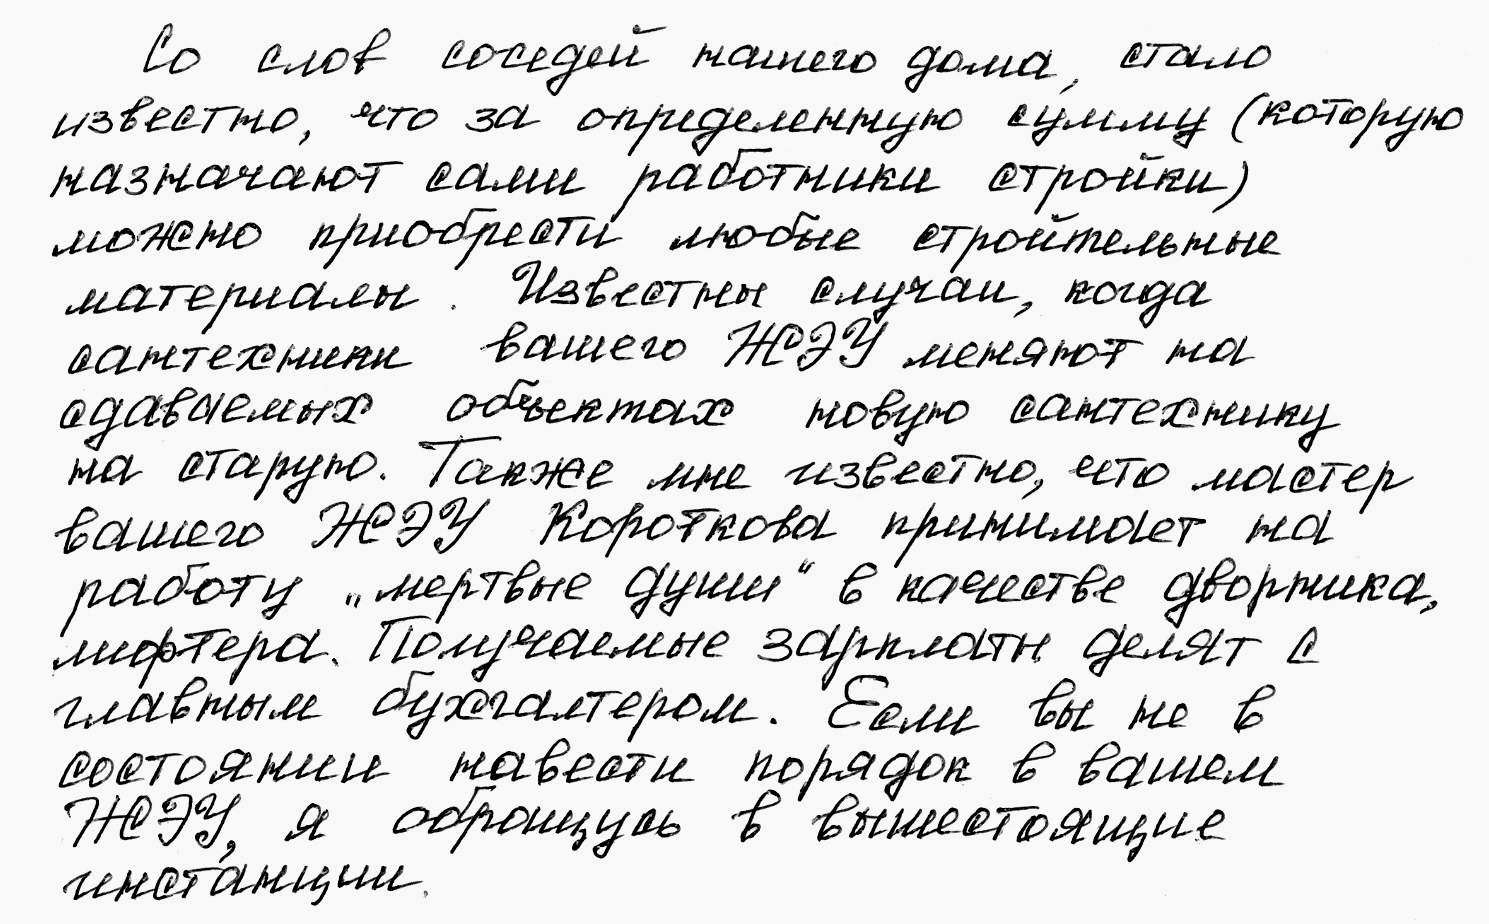

In [7]:
def load_image_from_url(url):
  return Image.open(BytesIO(requests.get(url).content))

img = load_image_from_url("https://studfile.net/html/2706/132/html_cIRc0NvMni.aLWd/img-aNoHJl.png")
img

Теперь применим к этому распознавание рукописного текста:

In [8]:
res = ocr(img.convert('RGB'),model="handwritten",languages=["ru"])
res

{'result': {'textAnnotation': {'width': '1489',
   'height': '924',
   'blocks': [{'boundingBox': {'vertices': [{'x': '50', 'y': '40'},
       {'x': '50', 'y': '900'},
       {'x': '1488', 'y': '900'},
       {'x': '1488', 'y': '40'}]},
     'lines': [{'boundingBox': {'vertices': [{'x': '161', 'y': '40'},
         {'x': '161', 'y': '75'},
         {'x': '1288', 'y': '75'},
         {'x': '1288', 'y': '40'}]},
       'text': 'Со слов соседей наинего дома, стало',
       'words': [{'boundingBox': {'vertices': [{'x': '161', 'y': '34'},
           {'x': '161', 'y': '77'},
           {'x': '227', 'y': '77'},
           {'x': '227', 'y': '34'}]},
         'text': 'Со',
         'entityIndex': '-1',
         'textSegments': [{'startIndex': '0', 'length': '2'}]},
        {'boundingBox': {'vertices': [{'x': '259', 'y': '35'},
           {'x': '259', 'y': '78'},
           {'x': '403', 'y': '78'},
           {'x': '403', 'y': '35'}]},
         'text': 'слов',
         'entityIndex': '-1',
      

In [9]:
text = res['result']['textAnnotation']['fullText']
text

'Со слов соседей наинего дома, стало\nизвестно, что за определенную гумму (которую\nназначают сами работники стройки)\nможно приобреати любые етройтельные\nматериалы. Исвестны влучаи, когда\nвантехнипи вашего НРЭУ меняют на\nодаваемых объектах новую сантехнику\nна старую. Также мне известно, есто мастер\nвашего Короткова принимоlet на\nработу "мертвые души" в начистве двортика,\nлифтера. Получаемые зарплаты делят\nглавным бухгаятером. Если вы не в\nсостоянии навести порядок в вашем\nобращуль в вышестоящие\nинстанции.\n'

Текст получился с ошибками, характерными для распознавания текста. Как можно его улучшить? Попробуем сделать это с помощью большой языковой модели Yandex GPT.

Для работы с языковыми моделями можно использовать библиотеку `langchain`. Вот так просто можно вызывать YandexGPT (а также другие языковые модели) из кода на Python:

In [10]:
from langchain_community.llms import YandexGPT
GPT = YandexGPT(api_key=api_key, folder_id=folder_id)

GPT.invoke("Расскажи анекдот про ИИ")

'Встретились как-то искусственный интеллект и человек.\n\nИИ говорит:\n\n— Я могу решить любую задачу, написать любой текст и создать любое произведение искусства.\n\nЧеловек отвечает:\n\n— А я могу пойти на кухню, поставить чайник, сделать бутерброд и получить от этого удовольствие.'

Теперь попросим YandexGPT исправить ошибки в нашем распознанном тексте:

In [11]:
prompt = """
Ты - редактор текстов. Тебе на редактуру пришел текст, полученный с помощью
автоматического сервиса распознавания рукописного текста. Из-за этого в тексте
содержится много опечаток и ошибок. Пожалуйста, отредактируй этот текст, исправив
все ошибки и опечатки, но не меняя смысла текста. Текст ниже:
{}
"""

GPT.invoke(prompt.format(text))

'Со слов соседей нашего дома стало известно, что за определённую сумму (которую назначают сами работники стройки) можно приобретать любые строительные материалы. Известны случаи, когда сантехники вашего НРЭУ меняют на подаваемых объектах новую сантехнику на старую. Также мне известно, что мастер вашего Короткова принимает на работу «мёртвые души» в качестве дворника и лифтера. Получаемые зарплаты делят с главным бухгалтером. Если вы не в состоянии навести порядок, обращайтесь в вышестоящие инстанции.'

Подробнее про языковые модели и про работу с ними мы расскажем в нашей следующей лекции.

## Рисуем с Yandex ART

В облаке Yandex Cloud доступна генеративная модель Yandex ART для рисования изображений по текстовому запросу. Она работает в **асинхронном режиме**:

- Сначала мы отправляем запрос на рисование картинки и получаем от сервиса уникальный `id`, с помощью которого мы можем проверять готовность картинки
- Отдельная функция служит для проверки готовности картинки и её получения.

Опишем эти функции:

In [12]:
def submit_art(prompt):
    res = call_api("https://llm.api.cloud.yandex.net/foundationModels/v1/imageGenerationAsync",
    {
        "modelUri": f"art://{folder_id}/yandex-art/latest",
        "messages": [
          {
            "weight": 1,
            "text": prompt
          }
        ]
    })
    if 'error' in res:
        print(res)
        return None
    return res['id']

id = submit_art('Нарисуй сферического коня в вакууме')
print(f"Получен идентификатор = {id}")

Получен идентификатор = fbvjam6po55heofkpm0c


Теперь проверяем готовность картинки. Возможно, придётся выполнить ячейку несколько раз, прежде чем картинка появится

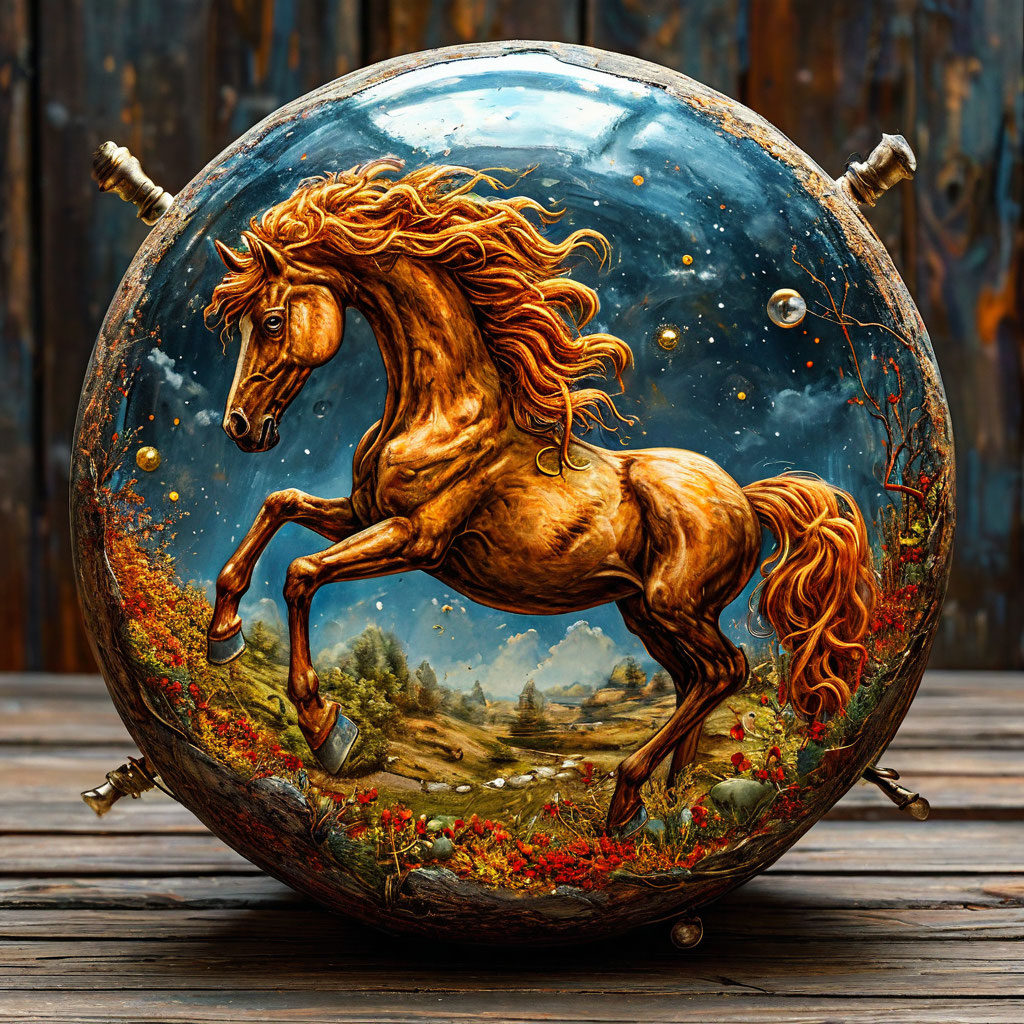

In [13]:
import io
from PIL import Image
import base64

def decode_image(base64_str):
    return Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))

def check(id):
    res = call_api_get(f"https://llm.api.cloud.yandex.net:443/operations/{id}",{})
    if 'done' in res and res['done']:
        return decode_image(res['response']['image'])
    else:
        return None

res = check(id)
res

На практике это означает, что нам нужно будет организовать ожидание, пока картинка не будет готова. Это можно собрать в одну функцию:

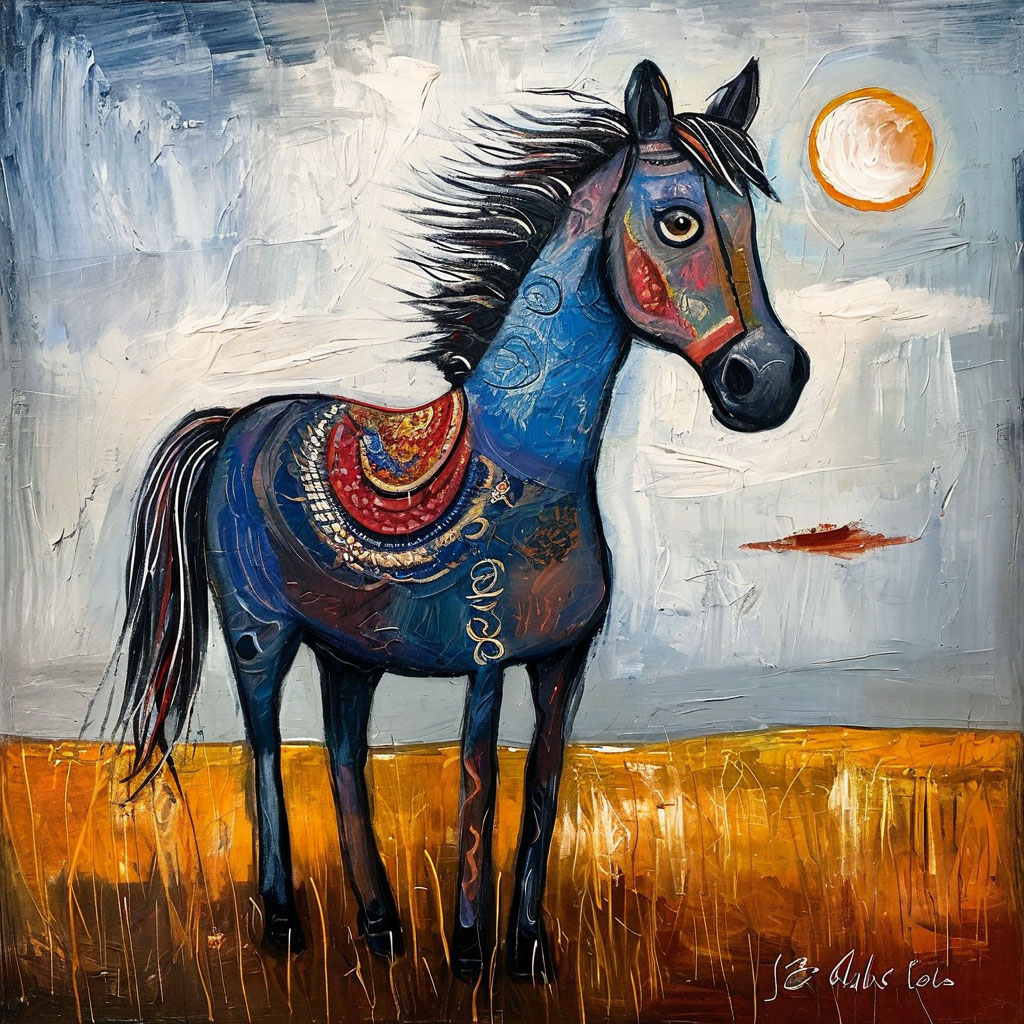

In [15]:
import time

def draw_picture(txt):
    id = submit_art(txt)
    while True:
        time.sleep(3)
        res = check(id)
        if res:
            return res

draw_picture('Лошадка в тумане в стиле Пикассо')

Теперь мы можем добавить к нашему веб-сайту небольщую картинную галерею. Перечислим название картин, которые мы хотим там видеть, сгенерируем их и заглавную веб-страничку.

In [24]:
import os

pictures = [
    'Купание синего коня, холст, масло',
    'Портет незнакомки в стиле кубизма',
    'Акварельные сумерки в городе'
]

os.makedirs('gallery',exist_ok=True)

#print('Генерирую картинки')
#for i,p in enumerate(pictures):
#  img = draw_picture(p)
#  img.save(f'gallery/{i}.png')

head = '''
<html>
  <head>
    <meta charset="utf-8"/>
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Yandex ART Gallery</title>
    <style>
        .gallery {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(150px, 1fr));
            gap: 10px;
            text-align: center;
        }
        .gallery img {
            width: 100%;
            height: auto;
            border-radius: 5px;
        }
        .caption {
            font-size: 14px;
            color: #555;
        }
    </style>
  </head>
  <body>
  <div class="gallery">
'''

print('Создаю сайт')
with open('gallery/index.html','w',encoding='utf-8') as f:
  f.write(head)
  for i,p in enumerate(pictures):
    f.write(f'<div><img src="{i}.png"/><div class="caption">{p}</div></div>')
  f.write('</div></body></html>')


Создаю сайт


Теперь открываем сайт в отдельном окне/вкладке браузера:

In [18]:
from google.colab.output import eval_js
print(eval_js( "google.colab.kernel.proxyPort(8000)" ))

https://rgpbbl06cj-496ff2e9c6d22116-8000-colab.googleusercontent.com/


In [25]:
!python -m http.server -d gallery

Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...
127.0.0.1 - - [26/Jan/2025 17:08:45] "GET /?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 17:08:45] "GET /0.png?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 17:08:45] "GET /1.png?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 17:08:45] "GET /2.png?authuser=0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2025 17:08:46] code 404, message File not found
127.0.0.1 - - [26/Jan/2025 17:08:46] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -

Keyboard interrupt received, exiting.


## Заключение

Мы познакомились с тем, как можно вызывать сложные модели ИИ, включая большие языковые модели и модели для генерации картинок по запросу, доступные как сервисы в облаке. И даже видели пример, как можно комбинировать эти сервисы как строительные блоки, чтобы решать более сложные задачи.

В следующей лекции мы подробнее поговорим про работу с текстом и языковые модели.